<a href="https://colab.research.google.com/github/OliviaHelena10/skincare_recommendations/blob/main/Colab_Predict_Skins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
# Basic DS libraries
import pandas as pd
import numpy as np

# Will help to list our files
from glob import glob
import pathlib
import PIL

# Will help us with the images
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Organising our Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Getting our data path:

In [ ]:
# Here we are accessing our data from google drive
path_train = '/content/drive/MyDrive/skin_search/train'

Saving the paths in variables:

Checking the categories:

In [ ]:
path = '/content/drive/MyDrive/skin_search/train'
data_dir = pathlib.Path(path)


# Iterating through the train subfolders and getting their names just in case
train_subfolders = [f.name for f in data_dir.iterdir() if f.is_dir()]
print(f'train: {train_subfolders}')

train: ['normal', 'oily', 'dry']


In [ ]:
for subfolder in train_subfolders:
  path =  data_dir / subfolder
  images = list(path.glob('*.jpg'))
  print(f'{subfolder}: {len(images)} imagens')

normal: 362 imagens
oily: 94 imagens
dry: 197 imagens


In [ ]:
# Checking our Datas

for subfolder in train_subfolders:                # iterates through the subfolders: dry, normal and oily
  path =  data_dir / subfolder                   # gets the path of each image
  images = list(path.glob('*.jpg'))               # gets the images of each subfolder
  print(f'\n{subfolder}: {len(images)} imagens')  # prints the number of data in each subfolder

  if images:
    img = PIL.Image.open(str(images[0]))          # opens the first image in the list
    img_array = np.array(img)                     # converts the image to a numpy array
    print(f'dimensões da primeira imagem em {subfolder} : {img_array.shape}\n') # gets our image dimensions
  print("------------------------------------------------------")


normal: 362 imagens
dimensões da primeira imagem em normal : (640, 640, 3)

------------------------------------------------------

oily: 94 imagens
dimensões da primeira imagem em oily : (640, 640, 3)

------------------------------------------------------

dry: 197 imagens
dimensões da primeira imagem em dry : (640, 640, 3)

------------------------------------------------------


# Image preprocessing for model training

Defining Variables:

In [ ]:
# We must maintain tha same proportions of the images width and height
image_width = 640
image_height = 640


# Images always have 3 color dimensions RGB pr BGR        ( R for Red  -  G for Green  -  B for Blue )
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
img_shape = image_size + (image_color_channel,)

batch_size = 64             # number of features that I will bring at a time from my dataset
epocas = 20                 # number of times that I will iterate trought my dataset
learning_rate = 0.0001

class_names = ['dry', 'normal', 'oily']

Separating train, test and validation data

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,       # 20% of our data for train
    subset = 'training',
    seed = 568,                   # this will get random weights for the transformations
    image_size = (image_height,image_width),
    batch_size = batch_size
)

Found 653 files belonging to 3 classes.
Using 523 files for training.


In [ ]:
validation = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,      # 80% of our data for validation
    subset = 'validation',
    seed = 568,                  # this will get random weights for the transformations
    image_size = (image_height,image_width),
    batch_size = batch_size
)

Found 653 files belonging to 3 classes.
Using 130 files for validation.


# Creating a Machine Learning Supervised Learning model - type Image Classification

In [ ]:
model1 = tf.keras.models.Sequential([

    # Input:
    tf.keras.layers.Input(shape=(640, 640,  3)),                                # This are the dimensions from our input data

    # Reescaling Layers
    tf.keras.layers.Rescaling(1./255),                                          # Normalizing our data by reescaling the pixels

    # Padding Layers
    tf.keras.layers.Flatten(),                                                  # Flattening our data to 1 dimension

    # Hidden Layers:
    tf.keras.layers.Dense(128,activation=tf.nn.relu),                           # Dense Layer will do the "math" for getting our results

    # Output:
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)                          # Softmax activation is used for cathegorical data and 3 are the dimensions in our dataset
])

In [ ]:
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 640, 640, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1228800)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │     157,286,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,286,915 (600.00 MB)

 Trainable params: 157,286,915 (600.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.compile(optimizer = tf.keras.optimizers.Adam(),           # Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
              loss='sparse_categorical_crossentropy',           # Will show the lesses of our training
              metrics=['accuracy'])                             # List of metrics to be evaluated by the model during training and testing.

In [ ]:
history = model1.fit(
    train,
    validation_data = validation,
    epochs = epocas # quantity of iterations
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4507 - loss: 423.7953 - val_accuracy: 0.2846 - val_loss: 158.7890
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3874 - loss: 113.9519 - val_accuracy: 0.4154 - val_loss: 84.4744
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5280 - loss: 56.2499 - val_accuracy: 0.5231 - val_loss: 52.8462
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5474 - loss: 32.3083 - val_accuracy: 0.4077 - val_loss: 44.1236
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4458 - loss: 57.8008 - val_accuracy: 0.4846 - val_loss: 113.9598
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4918 - loss: 68.1380 - val_accuracy: 0.4154 - val_loss: 66.7306
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 948ms/step - accuracy: 0.5468 - loss: 40.7139 - val_accuracy: 0.4077 - val_loss: 43.5866
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 975ms/step - accuracy: 0.5997 - loss: 23.7112 - val_accuracy: 0.4538 - va

# Plotting our results in graphics

In [ ]:
def plot_results(history, epocas):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss =  history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epocas)

  plt.figure(figsize=(12, 6))
  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, 'r', label='Acurácia do Treino')
  plt.plot(epochs_range, val_acc, 'b', label='Acurácia da Validação')
  plt.legend(loc = 'lower right')

  plt.subplot(1,2,2)

  plt.plot(epochs_range, loss, 'r', label = 'Perda do Treino')
  plt.plot(epochs_range, val_loss, 'b', label = 'Perda da Validação')
  plt.legend(loc = 'upper right')

  plt.show()

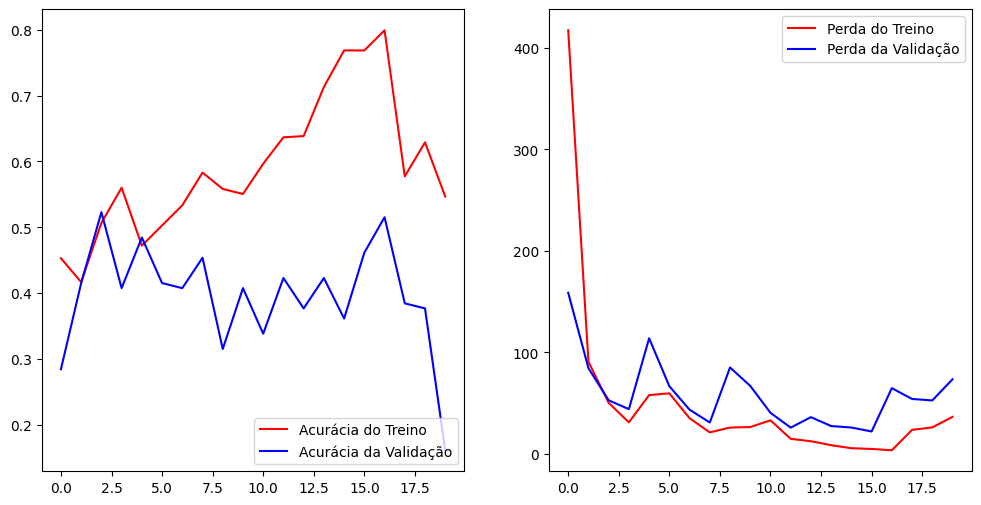

In [ ]:
plot_results(history,epocas)

In [ ]:
tf.random.set_seed(245)

In [ ]:
model2 = tf.keras.models.Sequential([

    # Input:
    tf.keras.layers.Input(shape=(640, 640,  3)),                                # This are the dimensions from our input data

    # Reescaling Layers:
    tf.keras.layers.Rescaling(1./255),                                          # Normalizing our data by reescaling the pixels

    # Hidden Layer 1:
    tf.keras.layers.Conv2D(6, (3,3), activation = tf.nn.relu),                 # This layers will apply filters with a convolutional network
                                                                                # 3,3 --> pixels          6 --> number of differents types of filters
    # Reducing Layer:
    tf.keras.layers.MaxPooling2D(2,2),                                          # This layers will reduce the dimensionality of the feature maps

    # Flattening Layers:
    tf.keras.layers.Flatten(),                                                  # Flattening our data to 1 dimension

    # Hidden Layer 2:
    tf.keras.layers.Dense(128,activation=tf.nn.relu),                           # Dense Layer will do the "math" for getting our results

    # Output:
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)                          # Softmax activation is used for cathegorical data and 3 are the dimensions in our dataset
])

In [ ]:
model2.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epocas = 20
history = model2.fit(
    train,
    validation_data = validation,
    epochs = epocas
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4377 - loss: 35.5575 - val_accuracy: 0.5077 - val_loss: 4.9587
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4065 - loss: 2.5179 - val_accuracy: 0.3308 - val_loss: 1.4565
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 999ms/step - accuracy: 0.3656 - loss: 1.2019 - val_accuracy: 0.3538 - val_loss: 1.1295
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 920ms/step - accuracy: 0.5572 - loss: 0.9743 - val_accuracy: 0.5000 - val_loss: 1.0804
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 919ms/step - accuracy: 0.7297 - loss: 0.9142 - val_accuracy: 0.4769 - val_loss: 1.0667
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7712 - loss: 0.8330 - val_accuracy: 0.4769 - val_loss: 1.2290
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6850 - loss: 0.7153 - val_accuracy: 0.4846 - val_loss: 1.0734
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 906ms/step - accuracy: 0.7573 - loss: 0.6665 - val_accuracy: 0.5154 - val_loss: 1.19

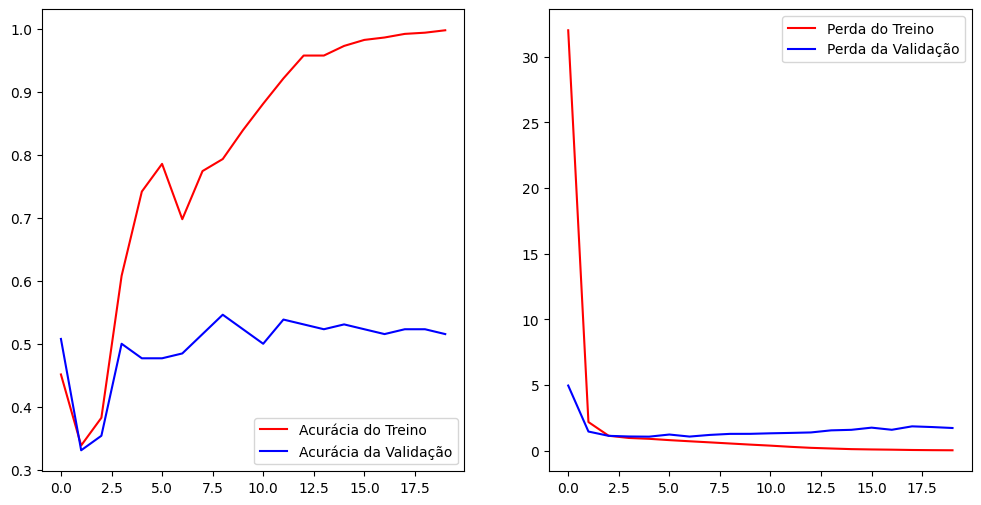

In [ ]:
plot_results(history,epocas)

# Saving the model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
modelo_tflite_quantizado = converter.convert()
with open('modelo_quantizado16bits.tflite', 'wb') as f:
    f.write(modelo_tflite_quantizado)

Saved artifact at '/tmp/tmp_xy7p84e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 640, 640, 3), dtype=tf.float32, name='keras_tensor_33')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134500846166512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134500846170384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134500846168976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134500846172144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134500846165280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134500846173728: TensorSpec(shape=(), dtype=tf.resource, name=None)
